In [1]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from random import random
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

---
## 1st Dataset : John Hopkins Data

In [2]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
print("Confirmed data shape : " + str(cumulated_confirmed_country.shape))
print("Recovered data shape : " + str(cumulated_deaths_country.shape))
print("Deaths data shape : " + str(cumulated_recovered_country.shape))

Confirmed data shape : (188, 164)
Recovered data shape : (188, 164)
Deaths data shape : (188, 164)


In [4]:
# ## To find specific instances on certain countries
# ## Consider grouping by countries to simplify the analysis process
# cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()

In [5]:
cumulated_confirmed_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,1962,1995,2047,2114,2192,2269,2330,2402,2466,2535
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,183,186,189,197,212,212,259,267,276,284


In [6]:
unique_countries = cumulated_confirmed_country["Country/Region"].unique()

In [7]:
cumulated_deaths_country[cumulated_deaths_country["Country/Region"]=="Taiwan*"]


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20
165,Taiwan*,23.7,121.0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


In [8]:
## Call this only if you wanna wait forever
proceed = False
if proceed:
    for country in unique_countries:
        covid_lib.plt_all_cases_increase_cases(country, cumulated_confirmed_country  )

In [9]:
# US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
# US_confirmed

# all_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

In [10]:
# plot_acf(temp_data, lags = 20 , alpha = 0.05) 
# plot_acf(increased_case.dropna())
# plot_pacf(increased_case.dropna())

### Taiwan Analysis

In [11]:
TW_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="Taiwan*"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(TW_confirmed, 7)


In [12]:
### TODO : I doing SARIMA on the total or the increase index?

---

### Changes in total Cases

In [13]:

# SARIMA example
model = SARIMAX(total_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=True)
yhat = model_fit.predict(len(total_cases), len(total_cases)+100)
print(yhat)

[447.00080778 447.00118604 447.0017136  447.00219638 447.00269162
 447.00318355 447.00367633 447.00416889 447.00466151 447.00515411
 447.00564672 447.00613933 447.00663194 447.00712454 447.00761715
 447.00810976 447.00860237 447.00909498 447.00958758 447.01008019
 447.0105728  447.01106541 447.01155801 447.01205062 447.01254323
 447.01303584 447.01352844 447.01402105 447.01451366 447.01500627
 447.01549887 447.01599148 447.01648409 447.0169767  447.0174693
 447.01796191 447.01845452 447.01894713 447.01943974 447.01993234
 447.02042495 447.02091756 447.02141017 447.02190277 447.02239538
 447.02288799 447.0233806  447.0238732  447.02436581 447.02485842
 447.02535103 447.02584363 447.02633624 447.02682885 447.02732146
 447.02781406 447.02830667 447.02879928 447.02929189 447.0297845
 447.0302771  447.03076971 447.03126232 447.03175493 447.03224753
 447.03274014 447.03323275 447.03372536 447.03421796 447.03471057
 447.03520318 447.03569579 447.03618839 447.036681   447.03717361
 447.0376662

### Changes in increase curve

In [14]:
 
# SARIMA example
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
# contrived dataset
# data = [x + random() for x in range(1, 100)]
# fit model
model = SARIMAX(increased_case.dropna(), order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=True)
# make prediction
yhat = model_fit.predict(len(increased_case.dropna()), len(increased_case.dropna())+100)
print(yhat)

2020-07-01    0.999987
2020-07-02    0.999982
2020-07-03    0.999973
2020-07-04    0.999966
2020-07-05    0.999959
                ...   
2020-10-05    0.999271
2020-10-06    0.999264
2020-10-07    0.999256
2020-10-08    0.999249
2020-10-09    0.999241
Freq: D, Length: 101, dtype: float64


/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



---

In [15]:
covid_lib.plot_all( total_cases, increased_case, yhat , "Taiwan" )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'yhat')

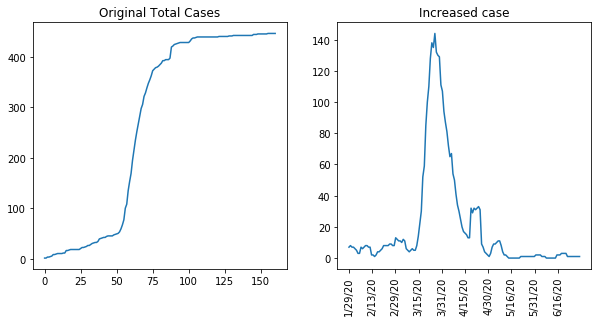

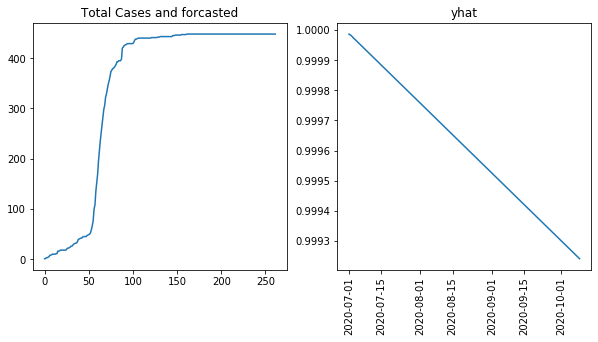

In [16]:

### Plotting

predicted_cases = np.concatenate((total_cases[:,0], yhat + total_cases[-1,0]))

figure = plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title("Original Total Cases")
plt.plot(total_cases)

plt.subplot(2,2,2)
plt.plot(increased_case.dropna())
plt.title("Increased case")
plt.xticks(rotation=90)
plt.xticks(np.arange(0, len(increased_case.dropna()), (len(increased_case.dropna()) / 10))) 

figure = plt.figure(figsize = (10,10))
plt.subplot(2,2,3)
plt.plot(predicted_cases)
plt.title("Total Cases and forcasted")


plt.subplot(2,2,4)
plt.plot(yhat)
plt.xticks(rotation=90)
plt.title("yhat")
